In [14]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
train = pd.read_csv('trains.csv')
test = pd.read_csv('test.csv')

for col in train.columns:
    col_type = train[col].dtypes
    min1 = train[col].min()
    max1 = train[col].max()
    if str(col_type)[:3] == 'int':
        train[col] = train[col].astype(np.int16)
    else:
        if min1 > np.finfo(np.float16).min and max1 < np.finfo(np.float16).max:
            train[col] = train[col].astype(np.float16)
        elif min1 > np.finfo(np.float32).min and max1 < np.finfo(np.float32).max:
            train[col] = train[col].astype(np.float32)
        else:
            train[col] = train[col].astype(np.float64)
train = train.sample(frac=1).reset_index(drop=True)
train_X = train.iloc[:,4:]
train_Y = train.iloc[:,0:4]
test_X = test.iloc[:,1:]

In [15]:
train_Y.head()

,layer_1,layer_2,layer_3,layer_4
0,200,60,200,40
1,150,300,280,270
2,130,50,30,130
3,110,60,110,190
4,60,90,60,60


In [31]:
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras import optimizers
from keras import activations
def build_model():
    model = Sequential()
    model.add(Dense(units=239, activation=mish, input_dim=226))
    model.add(BatchNormalization())
    model.add(Dropout(0.07338))
    model.add(Dense(units=252, activation=mish, input_dim=226))
    model.add(Dense(units=252, activation=mish, input_dim=226))
    model.add(BatchNormalization())
    model.add(Dropout(0.07338))
    model.add(Dense(units=265, activation=mish, input_dim=226))
    model.add(Dense(units=265, activation=mish, input_dim=226))
    model.add(BatchNormalization())
    model.add(Dropout(0.07338))
    model.add(Dense(units=178, activation=mish, input_dim=226))
    model.add(Dense(units=178, activation=mish, input_dim=226))
    model.add(BatchNormalization())
    model.add(Dropout(0.07338))
    model.add(Dense(units=91, activation=mish, input_dim=226))
    model.add(Dense(units=91, activation=mish, input_dim=226))
    model.add(Dense(units=4, activation='linear'))
    op = optimizers.Nadam(learning_rate = 0.001014, beta_1 = 0.9, beta_2 = 0.999)
    model.compile(loss='mae', optimizer=op, metrics=['mae'])
    return model
def swish(x) :
    return x * keras.activations.sigmoid(x)

def mish(x) :
    return x * keras.activations.tanh( keras.activations.softplus(x)) 

In [30]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt
import keras.backend as K
plt.figure(figsize = (13,8))
class LRFinder(Callback):
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.ylim(0, 10)

<Figure size 936x576 with 0 Axes>

In [35]:
epochs = 100
batch_size = 1000
epoch_size = len(train_X)

lr_finder = LRFinder(min_lr=(1e-3), 
                     max_lr=(1e-3)*5, 
                     steps_per_epoch=np.ceil(epoch_size/batch_size), 
                     epochs=epochs)

early_stop = keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')

ckpt_dir = './ckpt1'
ckpt_path = ckpt_dir + '/ResNetFinetuning_{epoch:02d}_valloss{val_loss:.2f}.hdf5'
ckpt = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

In [12]:
model11 = build_model()
model11.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 239)               54253     
_________________________________________________________________
batch_normalization_5 (Batch (None, 239)               956       
_________________________________________________________________
dropout_5 (Dropout)          (None, 239)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 252)               60480     
_________________________________________________________________
dense_13 (Dense)             (None, 252)               63756     
_________________________________________________________________
batch_normalization_6 (Batch (None, 252)               1008      
_________________________________________________________________
dropout_6 (Dropout)          (None, 252)              

In [19]:
model11 = build_model()
model11.fit(train_X, train_Y, epochs=100,callbacks=[ckpt, lr_finder], batch_size=1000, validation_split = 0.2,shuffle=True,)

Train on 648000 samples, validate on 162000 samples
Epoch 1/100
648000/648000 [==============================] - 16s 24us/step - loss: 59.4536 - mae: 59.4536 - val_loss: 51.3733 - val_mae: 51.3733
Epoch 2/100
648000/648000 [==============================] - 13s 21us/step - loss: 29.8708 - mae: 29.8708 - val_loss: 17.9017 - val_mae: 17.9017
Epoch 3/100
648000/648000 [==============================] - 13s 21us/step - loss: 15.6355 - mae: 15.6355 - val_loss: 10.3255 - val_mae: 10.3255
Epoch 4/100
648000/648000 [==============================] - 13s 21us/step - loss: 12.1459 - mae: 12.1459 - val_loss: 8.8741 - val_mae: 8.8741
Epoch 5/100
648000/648000 [==============================] - 13s 21us/step - loss: 10.4858 - mae: 10.4858 - val_loss: 6.6851 - val_mae: 6.6851
Epoch 6/100
648000/648000 [==============================] - 13s 21us/step - loss: 9.4925 - mae: 9.4925 - val_loss: 6.8517 - val_mae: 6.8517
Epoch 7/100
648000/648000 [==============================] - 13s 21us/step - loss: 8.8

648000/648000 [==============================] - 13s 21us/step - loss: 4.4362 - mae: 4.4362 - val_loss: 3.4862 - val_mae: 3.4862
Epoch 59/100
648000/648000 [==============================] - 13s 21us/step - loss: 4.4822 - mae: 4.4822 - val_loss: 3.9906 - val_mae: 3.9906
Epoch 60/100
648000/648000 [==============================] - 13s 21us/step - loss: 4.3947 - mae: 4.3947 - val_loss: 3.2744 - val_mae: 3.2744
Epoch 61/100
648000/648000 [==============================] - 13s 21us/step - loss: 4.3829 - mae: 4.3829 - val_loss: 3.4634 - val_mae: 3.4634
Epoch 62/100
648000/648000 [==============================] - 13s 21us/step - loss: 4.3583 - mae: 4.3583 - val_loss: 4.0129 - val_mae: 4.0129
Epoch 63/100
648000/648000 [==============================] - 13s 21us/step - loss: 4.3465 - mae: 4.3465 - val_loss: 3.3655 - val_mae: 3.3655
Epoch 64/100
648000/648000 [==============================] - 13s 21us/step - loss: 4.3554 - mae: 4.3554 - val_loss: 3.2514 - val_mae: 3.2514
Epoch 65/100
648000

In [36]:
model1 = build_model()
model1.fit(train_X, train_Y, epochs=100,callbacks=[ckpt, lr_finder], batch_size=1000, validation_split = 0.15,shuffle=True,)

Train on 688500 samples, validate on 121500 samples
Epoch 1/100
688500/688500 [==============================] - 15s 22us/step - loss: 60.5772 - mae: 60.5772 - val_loss: 52.6091 - val_mae: 52.6091
Epoch 2/100
688500/688500 [==============================] - 15s 21us/step - loss: 32.6343 - mae: 32.6343 - val_loss: 20.8371 - val_mae: 20.8372
Epoch 3/100
688500/688500 [==============================] - 15s 21us/step - loss: 17.6451 - mae: 17.6451 - val_loss: 11.7109 - val_mae: 11.7109
Epoch 4/100
688500/688500 [==============================] - 15s 21us/step - loss: 13.6797 - mae: 13.6797 - val_loss: 9.5707 - val_mae: 9.5707
Epoch 5/100
688500/688500 [==============================] - 15s 21us/step - loss: 11.8811 - mae: 11.8811 - val_loss: 8.3446 - val_mae: 8.3446
Epoch 6/100
688500/688500 [==============================] - 14s 21us/step - loss: 10.7800 - mae: 10.7800 - val_loss: 7.0381 - val_mae: 7.0381TA: 0s - loss: 10.7928 - ma - ETA: 0s - loss: 10.7841 - mae: 10.
Epoch 7/100
688500/6

688500/688500 [==============================] - 14s 21us/step - loss: 4.7953 - mae: 4.7953 - val_loss: 3.4514 - val_mae: 3.4514
Epoch 58/100
688500/688500 [==============================] - 14s 21us/step - loss: 4.7359 - mae: 4.7359 - val_loss: 3.5123 - val_mae: 3.5123
Epoch 59/100
688500/688500 [==============================] - 14s 21us/step - loss: 4.6747 - mae: 4.6747 - val_loss: 3.3698 - val_mae: 3.3698
Epoch 60/100
688500/688500 [==============================] - 14s 21us/step - loss: 4.7008 - mae: 4.7008 - val_loss: 3.6173 - val_mae: 3.6173
Epoch 61/100
688500/688500 [==============================] - 14s 21us/step - loss: 4.6551 - mae: 4.6550 - val_loss: 3.2428 - val_mae: 3.2428
Epoch 62/100
688500/688500 [==============================] - 15s 21us/step - loss: 4.6617 - mae: 4.6617 - val_loss: 3.7092 - val_mae: 3.7092
Epoch 63/100
688500/688500 [==============================] - 14s 21us/step - loss: 4.6251 - mae: 4.6251 - val_loss: 3.2483 - val_mae: 3.2483
Epoch 64/100
688500

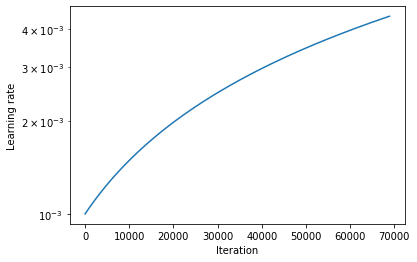

In [38]:
lr_finder.plot_lr()
# plt.xlim(1e-3,(1e-2))

In [42]:
model1.load_weights(ckpt_dir +'/ResNetFinetuning_70_valloss2.94.hdf5')
pred_test = model1.predict(test_X)
y_pred1 = pred_test
# model11.load_weights(ckpt_dir +'/ResNetFinetuning_77_valloss4.93.hdf5')
# pred_test = model11.predict(test_X)
# y_pred2 = pred_test
# # model11.load_weights(ckpt_dir +'/ResNetFinetuning_75_valloss0.09.hdf5')
# # pred_test = model11.predict(xscaler.transform(test_X))
# # y_pred3 = yscaler.inverse_transform(pred_test)
# model11.load_weights(ckpt_dir +'/ResNetFinetuning_73_valloss5.01.hdf5')
# pred_test = model11.predict(test_X)
# y_pred4 = pred_test

In [77]:
y_pred = (y_pred1+y_pred2+y_pred4)/3

In [43]:
sample = pd.read_csv("sample_submission.csv")
sample.iloc[:,1:] = y_pred1
sample.head()

,id,layer_1,layer_2,layer_3,layer_4
0,0,254.064392,231.065323,128.873032,89.407043
1,1,156.478638,126.821869,239.739456,99.346886
2,2,151.008453,180.336212,274.262939,161.574860
3,3,92.844887,234.588516,184.294617,86.483749
4,4,271.374878,294.000183,245.959915,272.282257


In [44]:
sample.to_csv("sample_sub1.csv",index=False)